## Instalando e Carregando os Pacotes

In [3]:
# Imports
import sklearn
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Carregando os Dados

In [5]:
# Carrega o dataset
dados = pd.read_csv('dados/dataset.csv')

In [6]:
dados.shape

(913000, 4)

In [7]:
dados.head()

,data,loja,produto,itens_vendidos
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
dados.describe()

,loja,produto,itens_vendidos
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [9]:
# Valores únicos da coluna loja
dados.loja.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
# Valores únicos da coluna produto
dados.produto.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

## Análise Exploratória

Vamos analisar o padrão de itens vendidos ao longo do tempo para a loja 1 e produto 1. Como dica de exercício reproduza este Jupyter Notebook para outras lojas e outros produtos.

In [11]:
# Filtra os dados da Loja 1
dados_ts = dados[dados['loja'] == 1]

In [12]:
# Filtra os dados do Produto 1
dados_ts = dados_ts[dados_ts['produto'] == 1]

In [13]:
# Filtramos as colunas de data e itens_vendidos que nos interessam
dados_ts = dados_ts[['data', 'itens_vendidos']]

In [14]:
# ATENÇÃO: ISSO AINDA NÃO É UMA SÉRIE TEMPORAL EM PYTHON!
dados_ts.head()

,data,itens_vendidos
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [15]:
# Define a coluna de data como índice (isso é o que caracteriza série temporal em Python)
dados_ts = dados_ts.set_index('data')

In [16]:
# ATENÇÃO: AGORA SIM É UMA SÉRIE TEMPORAL EM PYTHON!
dados_ts.head()

,itens_vendidos
data,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


([], [])

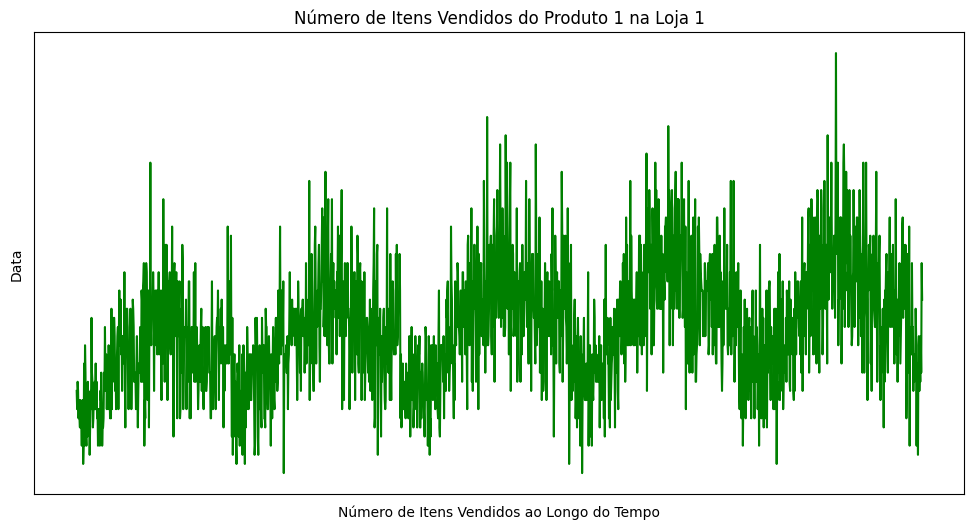

In [17]:
# Plot do comportamento geral da série temporal
plt.figure(figsize = (12,6))
plt.plot(dados_ts, color = 'green')
plt.xlabel('Número de Itens Vendidos ao Longo do Tempo')
plt.ylabel('Data')
plt.title("Número de Itens Vendidos do Produto 1 na Loja 1")
plt.xticks([]) 
plt.yticks([]) 

**Análise:**

Observamos um padrão de sazonalidade com picos superiores e inferiores. Vamos analisar outros gráficos em diferentes períodos de tempo.

([], [])

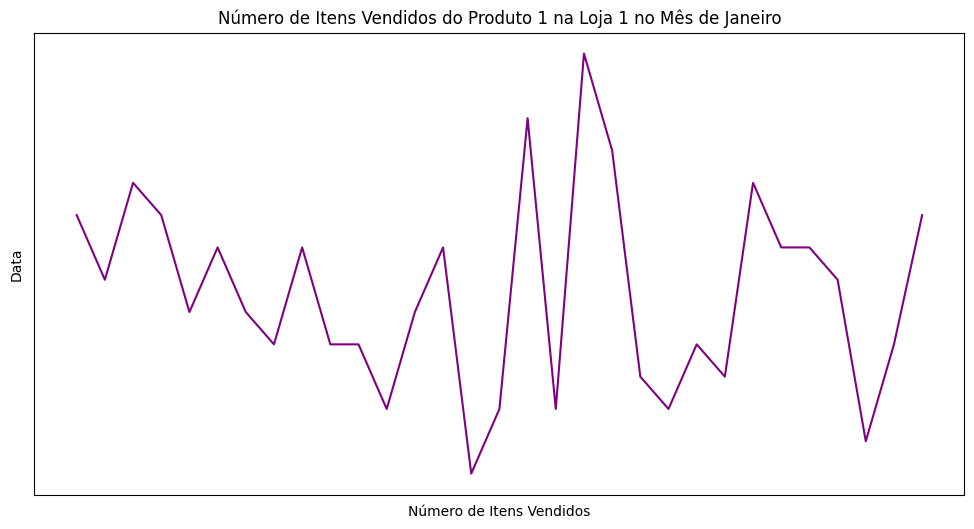

In [18]:
# Plot do comportamento semanal da série temporal (mês de Janeiro com 31 dias)
plt.figure(figsize = (12,6))
plt.plot(dados_ts[:31], color = 'purple')
plt.xlabel('Número de Itens Vendidos')
plt.ylabel('Data')
plt.title("Número de Itens Vendidos do Produto 1 na Loja 1 no Mês de Janeiro")
plt.xticks([]) 
plt.yticks([]) 

([], [])

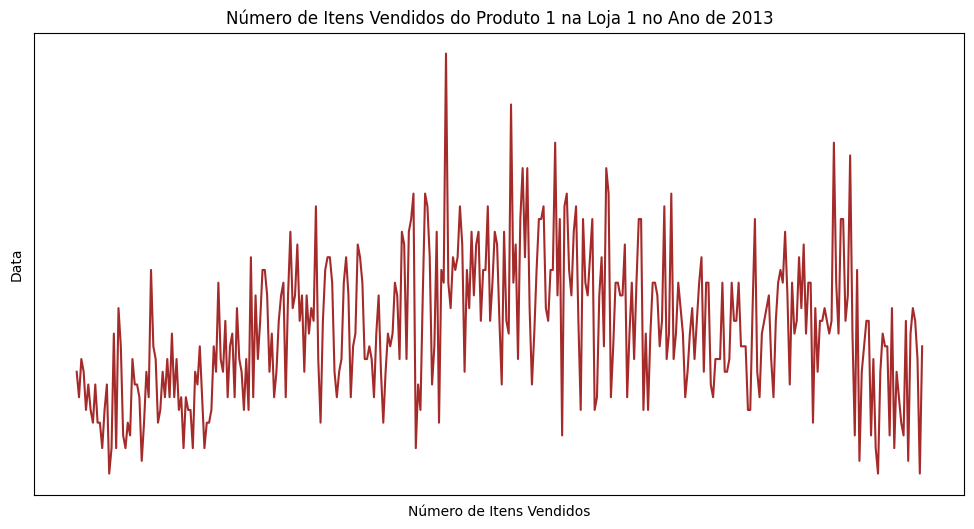

In [19]:
# Plot do comportamento mensal da série temporal para 1 ano (2013)
plt.figure(figsize = (12,6))
plt.plot(dados_ts[:365], color = 'brown')
plt.xlabel('Número de Itens Vendidos')
plt.ylabel('Data')
plt.title("Número de Itens Vendidos do Produto 1 na Loja 1 no Ano de 2013")
plt.xticks([]) 
plt.yticks([]) 

**Análise:**

Os gráficos confirmam que a série apresenta algum padrão. Vamos decompor a série em seus componentes.

## Decomposição da Série Temporal

In [20]:
# Decompondo a série temporal
resultado = seasonal_decompose(dados_ts['itens_vendidos'], model = 'additive', period = 365)

([], [])

<Figure size 640x480 with 0 Axes>

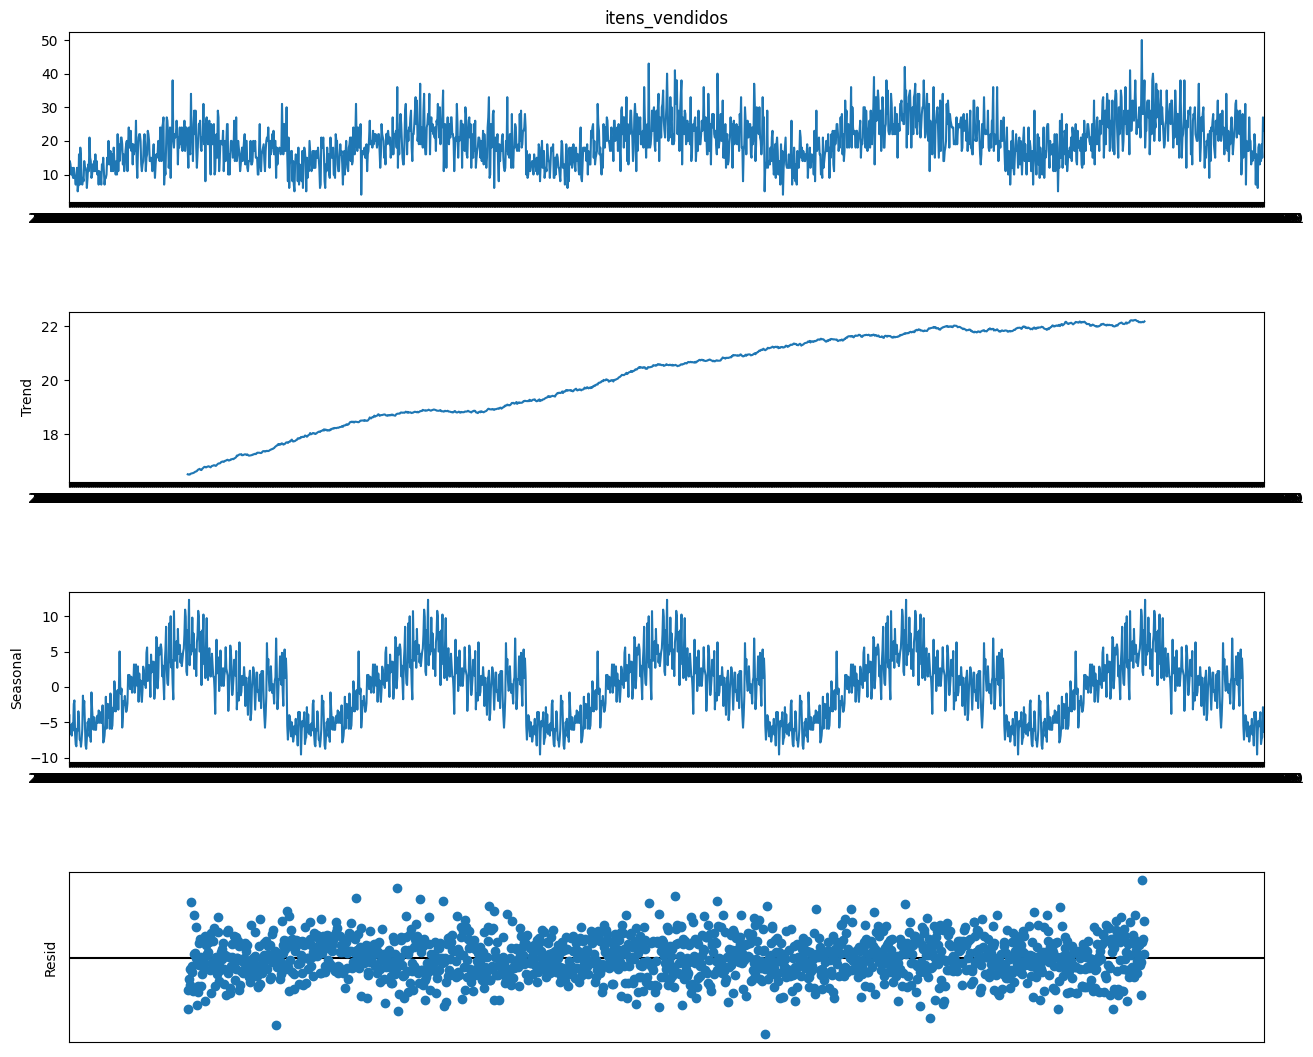

In [21]:
# Plot
fig = plt.figure()  
fig = resultado.plot()  
fig.set_size_inches(15, 12)
plt.xticks([]) 
plt.yticks([]) 

**Análise:**

A partir das figuras acima, podemos ver que a série temporal não é estacionária, pois apresenta sazonalidade e uma tendência ascendente.

Para dados estacionários:

* A média da série não deve ser uma função do tempo. A média deve estar perto de uma linha plana horizontal em vez de aumentar ou diminuir ao longo do tempo.
* A variância da série não deve ser função do tempo. Esta propriedade é conhecida como homocedasticidade.
* A covariância da série não deve ser função do tempo.

Também podemos usar o Teste Dickey-Fuller Aumentado para verificar se a série temporal é ou não estacionária.

Para usar modelos ARIMA, a série temporal **DEVE** ser estacionária. Os dados da série temporal devem ser estacionários para remover qualquer correlação óbvia e colinearidade com dados anteriores.

## Estacionaridade

Vamos criar uma função para visualizar a estacionaridade.

In [22]:
# Função para visualizar estacionaridade
def visualiza_estacionaridade(dados_serie):
    
    # Calcula média e desvio padrão móveis 
    rolling_mean = dados_serie.rolling(12).mean()
    rolling_std = dados_serie.rolling(12).std()
    
    # Plot
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(dados_serie, label = 'Itens Vendidos')
    mean = plt.plot(rolling_mean, color = 'yellow', label = "Média Móvel")
    std = plt.plot(rolling_std, color = 'green', label = "Desvio Padrão Móvel")
    
    plt.legend(loc = 'best')
    plt.title("Visualizando a Estacionaridade")
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

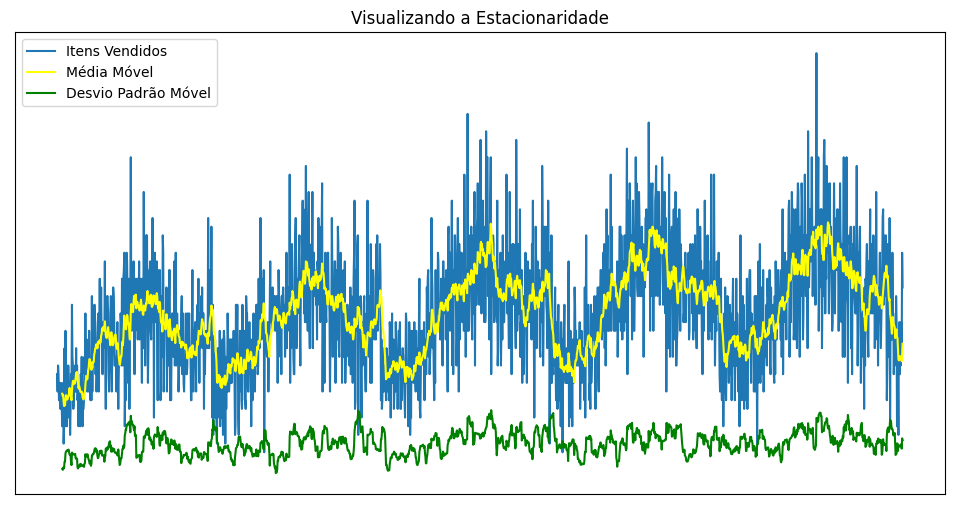

In [23]:
# Aplica a função
visualiza_estacionaridade(dados_ts)

**Análise:**

A série apresenta exatamente o oposto do que precisamos para poder criar um modelo ARIMA. Vamos aplicar um teste estatístico.

### Teste Dickey-Fuller Aumentado

* Um valor-p menor que 0,05 significa que podemos rejeitar a hipótese nula de que os dados da série temporal não são estacionários. Portanto, a série temporal é estacionária.

* Um valor-p maior que 0,05 significa que não rejeitamos a hipótese nula. Portanto, a série temporal não é estacionária.

In [24]:
# Aplica o teste
resultado_adft = adfuller(dados_ts)

In [25]:
resultado_adft

(-3.1576705563328105,
 0.022569380626571107,
 23,
 1802,
 {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913},
 10896.776833317934)

In [26]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


**Análise:**

Como o Teste Dickey-Fuller Aumentado nos deu um valor-p inferior a 0,05, isso significa que a série temporal é estacionária. No entanto, ao observar os gráficos, podemos perceber que há claros indícios de sazonalidade. A média parece ser uma função do tempo, uma vez que flutua com a data.

Como o valor-p não é assim tão baixo (embora seja menor que 0.05), vamos aplicar estacionaridade na série para satisfazer a suposição do modelo ARIMA.

## Estacionarização de Dados de Séries Temporais

### Diferenciação

A diferenciação é uma técnica usada para remover tendências se a série for estacionária em torno de uma tendência.

In [27]:
# Aplica a diferenciação
first_diff = dados_ts.itens_vendidos - dados_ts.itens_vendidos.shift(1)

In [28]:
# Remove valores NA gerados no processo
first_diff = first_diff.dropna()

([], [])

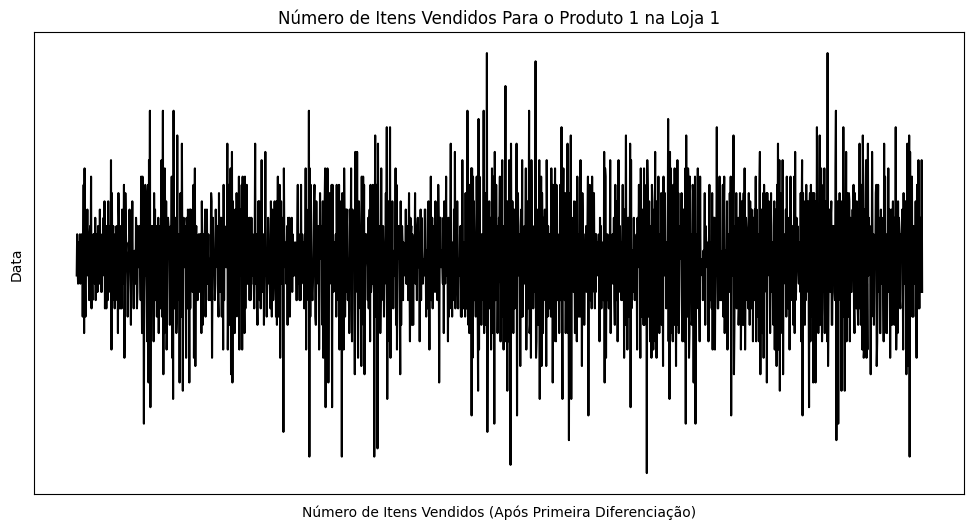

In [29]:
# Plot
plt.figure(figsize = (12,6))
plt.plot(first_diff, color = 'black')
plt.xlabel('Número de Itens Vendidos (Após Primeira Diferenciação)')
plt.ylabel('Data')
plt.title("Número de Itens Vendidos Para o Produto 1 na Loja 1")
plt.xticks([]) 
plt.yticks([])

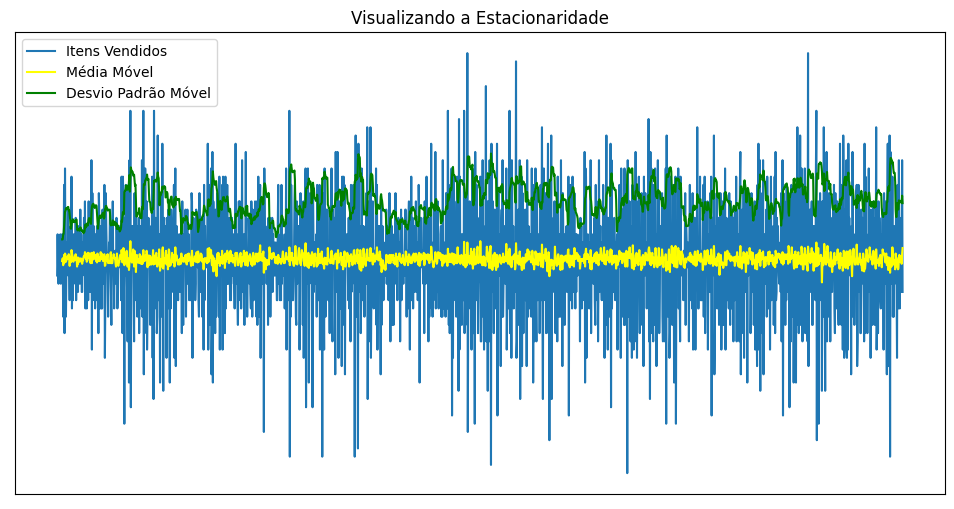

In [30]:
visualiza_estacionaridade(first_diff)

In [31]:
# Aplica o teste
resultado_adft = adfuller(first_diff)

In [32]:
# Valor-p resultado do teste
resultado_adft[1]

1.2109276320438467e-23

In [33]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


**Análise:**

Após a primeira diferenciação, podemos ver que a média móvel é uma linha horizontal e não é mais uma função do tempo. Exatamente o que esperamos de uma série para criar um modelo ARIMA.

Além disso, o valor-p obtido no Teste Dickey-Fuller Aumentado é extremamente baixo, praticamente zero. Esta série agora é realmente estacionária.

Podemos então criar nosso modelo ARIMA.

## Modelo SARIMAX

O modelo usado para previsão depende dos dados da série temporal. A série temporal precisa ser dividida para ver se contém ou não partes autorregressivas (AR) e partes de média móvel (MA), integração e sazonalidade.

Os gráficos de função de autocorrelação (ACF) e os gráficos de função de autocorrelação parcial (PACF) podem ser usados para determinar se a série temporal contém partes AR e MA.

Parâmetros que devem ser deifnidos para o modelo SARIMAX:

* p - número de atrasos ou lags (AR)
* d - número de diferenciações necessárias
* q - número de atrasos de erro (MA)
* P - número de atrasos sazonais (AR)
* D - número de diferenças sazonais necessárias
* Q - número de defasagens de erro sazonal (MA)
* S - sazonalidade

### Plots de Autocorrelação (ACF & PACF)

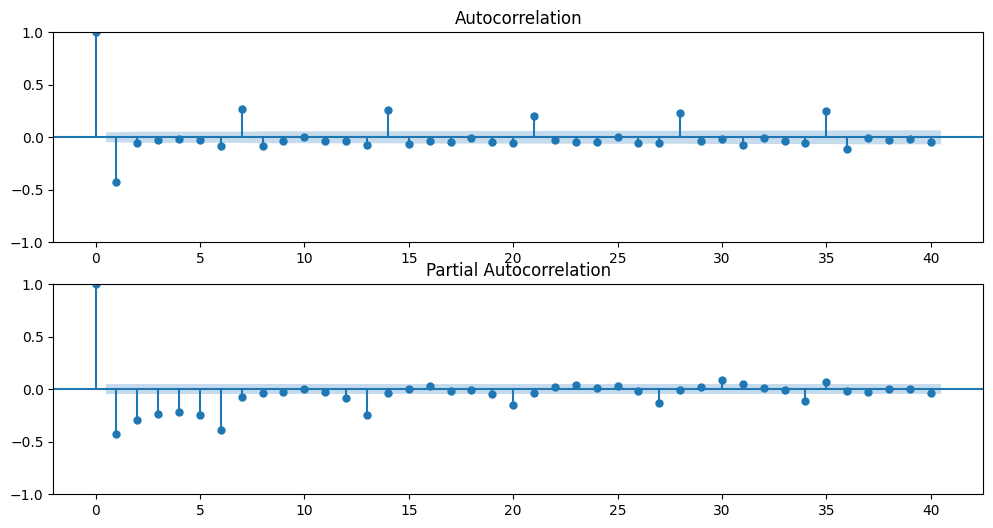

In [34]:
# Plot
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(first_diff, ax = axes[0], lags = 40)
axes[1] = plot_pacf(first_diff, ax = axes[1], lags = 40)

**Análise:**

A partir dos gráficos ACF e PACF, observamos que:

* Esperamos os círculos dentro da área sombreada azul para uma série com comportamento aleatório.


* Existem várias autocorrelações que estão fora da área azul. Isso indica que a série temporal não é totalmente aleatória.


* Há forte correlação em lag = 1, 7, 14, 21, 28, 35 para o gráfico ACF. Ocorre a cada 7 lags.


* Há forte correlação em lag = 1, 2, 3, 4, 5, 6, 13, 20, 27 para gráfico PACF. Ocorre em 6, seguido por atrasos a cada 7, mas diminui.

Com base nessa análise (e outras técnicas) definimos os parâmetros de ordem e ordem sazonal.

Vamos preparar os dados de treino e teste.

In [35]:
# Data limite
cutoff_date = '2017-10-01'

In [36]:
# Prepara datasets de treino e teste
amostra_treino = first_diff.loc[first_diff.index < cutoff_date]
amostra_teste = first_diff.loc[first_diff.index >= cutoff_date]

## Modelagem

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

Precisamos definir a ordem (p,d,q) do modelo para o número de parâmetros AR, diferenciações e parâmetros MA. d deve ser um número inteiro indicando a ordem de integração do processo, enquanto p e q podem ser números inteiros indicando as ordens AR e MA (para que todos os atrasos até essas ordens sejam incluídos) ou então iteráveis fornecendo AR e/ou MA específicos. O padrão é um modelo AR(1): (1,0,0).

Precisamos definir a ordem (P,D,Q,s) do componente sazonal do modelo para os parâmetros AR, diferenciações, parâmetros MA e periodicidade. D deve ser um número inteiro indicando a ordem de integração do processo, enquanto P e Q podem ser números inteiros indicando as ordens AR e MA (para que todos os atrasos até essas ordens sejam incluídos) ou então iteráveis fornecendo AR e/ou MA específicos. s é um inteiro que dá a periodicidade (número de períodos), muitas vezes é 4 para dados trimestrais ou 12 para dados mensais. O padrão é nenhum efeito sazonal.

In [37]:
# Cria o modelo SARIMAX
modelo = SARIMAX(amostra_treino, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,7))

In [38]:
# Treinamento do modelo
modelo_v1 = modelo.fit(disp = True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25903D+00    |proj g|=  1.83662D-01

At iterate    1    f=  3.23099D+00    |proj g|=  1.21263D-01

At iterate    2    f=  3.21507D+00    |proj g|=  6.05941D-02

At iterate    3    f=  3.21062D+00    |proj g|=  5.56203D-02

At iterate    4    f=  3.18997D+00    |proj g|=  4.70551D-02


 This problem is unconstrained.



At iterate    5    f=  3.17439D+00    |proj g|=  6.39871D-02

At iterate    6    f=  3.16098D+00    |proj g|=  7.61036D-02

At iterate    7    f=  3.15160D+00    |proj g|=  5.97888D-02

At iterate    8    f=  3.14904D+00    |proj g|=  1.41920D-02

At iterate    9    f=  3.14881D+00    |proj g|=  6.40424D-03

At iterate   10    f=  3.14869D+00    |proj g|=  7.32147D-03

At iterate   11    f=  3.14801D+00    |proj g|=  9.49521D-03

At iterate   12    f=  3.14632D+00    |proj g|=  2.04672D-02

At iterate   13    f=  3.14517D+00    |proj g|=  5.80215D-02

At iterate   14    f=  3.14311D+00    |proj g|=  1.93736D-02

At iterate   15    f=  3.14217D+00    |proj g|=  9.22829D-03

At iterate   16    f=  3.14177D+00    |proj g|=  5.09090D-03

At iterate   17    f=  3.14158D+00    |proj g|=  4.24299D-03

At iterate   18    f=  3.14150D+00    |proj g|=  5.52112D-03

At iterate   19    f=  3.14144D+00    |proj g|=  3.11374D-03

At iterate   20    f=  3.14142D+00    |proj g|=  9.91923D-04

At iter

In [39]:
# Previsões com o modelo para janela de 3 meses (meses 10, 11 e 12 de 2017)
previsoes = modelo_v1.predict(start = cutoff_date, end = '2017-12-31', dynamic = False)

In [40]:
# Aplica a diferenciação em teste
first_diff_teste = first_diff
first_diff_teste.index = pd.to_datetime(first_diff_teste.index)

Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

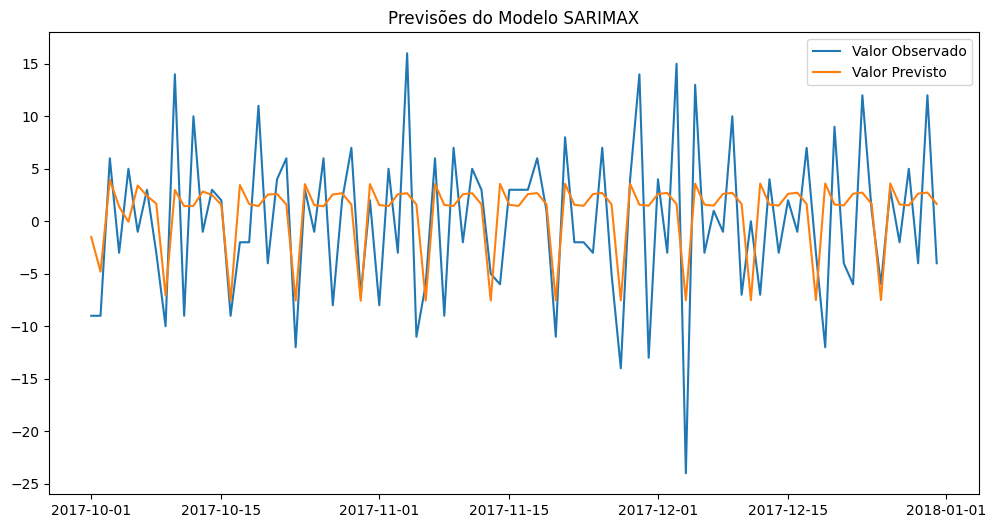

In [41]:
# Plot comparando previsões do modelo para 3 meses, com os dados de teste
fig = plt.figure(figsize = (12,6))
sales = plt.plot(first_diff_teste[cutoff_date:], label = 'Valor Observado')
forecast = plt.plot(previsoes, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

## Avaliação do Modelo

Usaremos o Erro Absoluto Médio (MAE) e o Erro Quadrático Médio (MSE) para avaliar o modelo.

In [42]:
# Erro do modelo - MAE
print('SARIMAX MAE = ', mean_absolute_error(previsoes, amostra_teste))

SARIMAX MAE =  5.211062365733839


In [43]:
# Erro do modelo - MSE
print('SARIMAX MSE = ', mean_squared_error(previsoes, amostra_teste))

SARIMAX MSE =  42.12337800116559


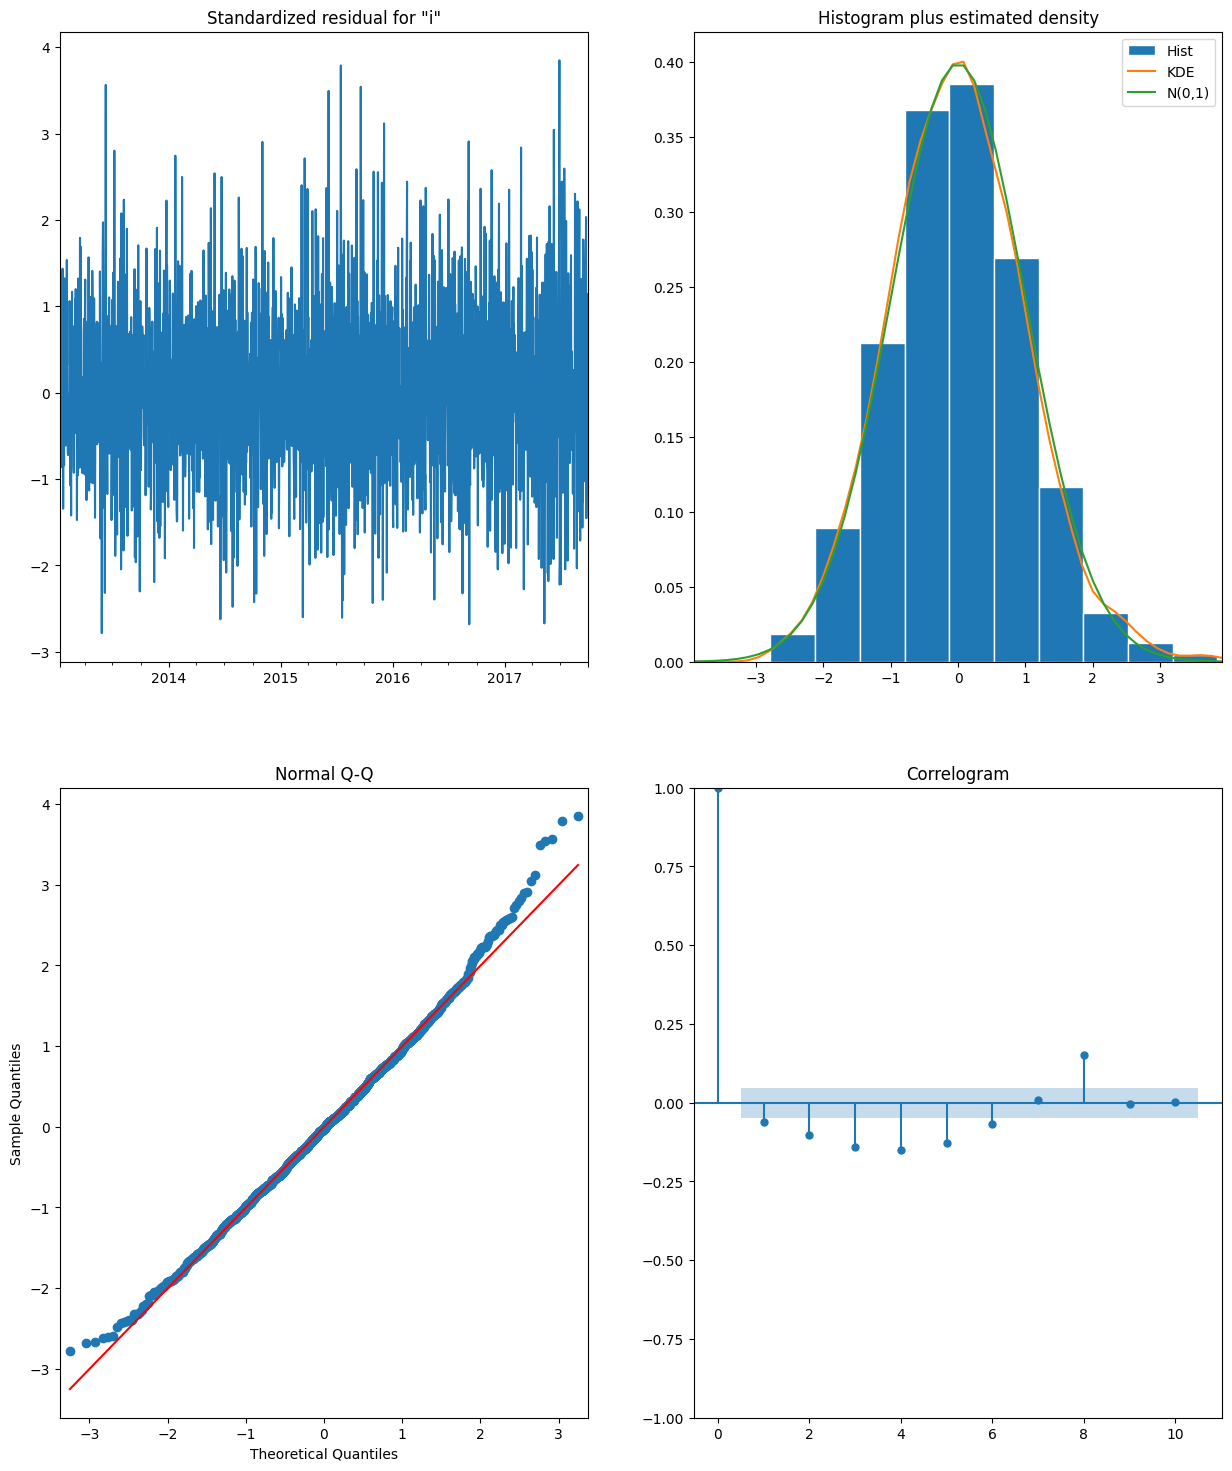

In [44]:
modelo_v1.plot_diagnostics(figsize = (15,18))
plt.show()